In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pymc3 as pm
import scipy.stats as stats

WARNING (theano.tensor.blas): Using NumPy C-API based implementation for BLAS functions.


In [2]:
%config InlineBackend.figure_format = 'retina'
%load_ext watermark
RANDOM_SEED = 8927
np.random.seed(RANDOM_SEED)
az.style.use("arviz-darkgrid")

## Analytical Computation

* Likelihood: $P[k|p] \sim Bin(n, p)$
* Prior: $P[p] \sim U(0, 1)$
* Posterior: $P[p|k] \sim Beta(n, k)$

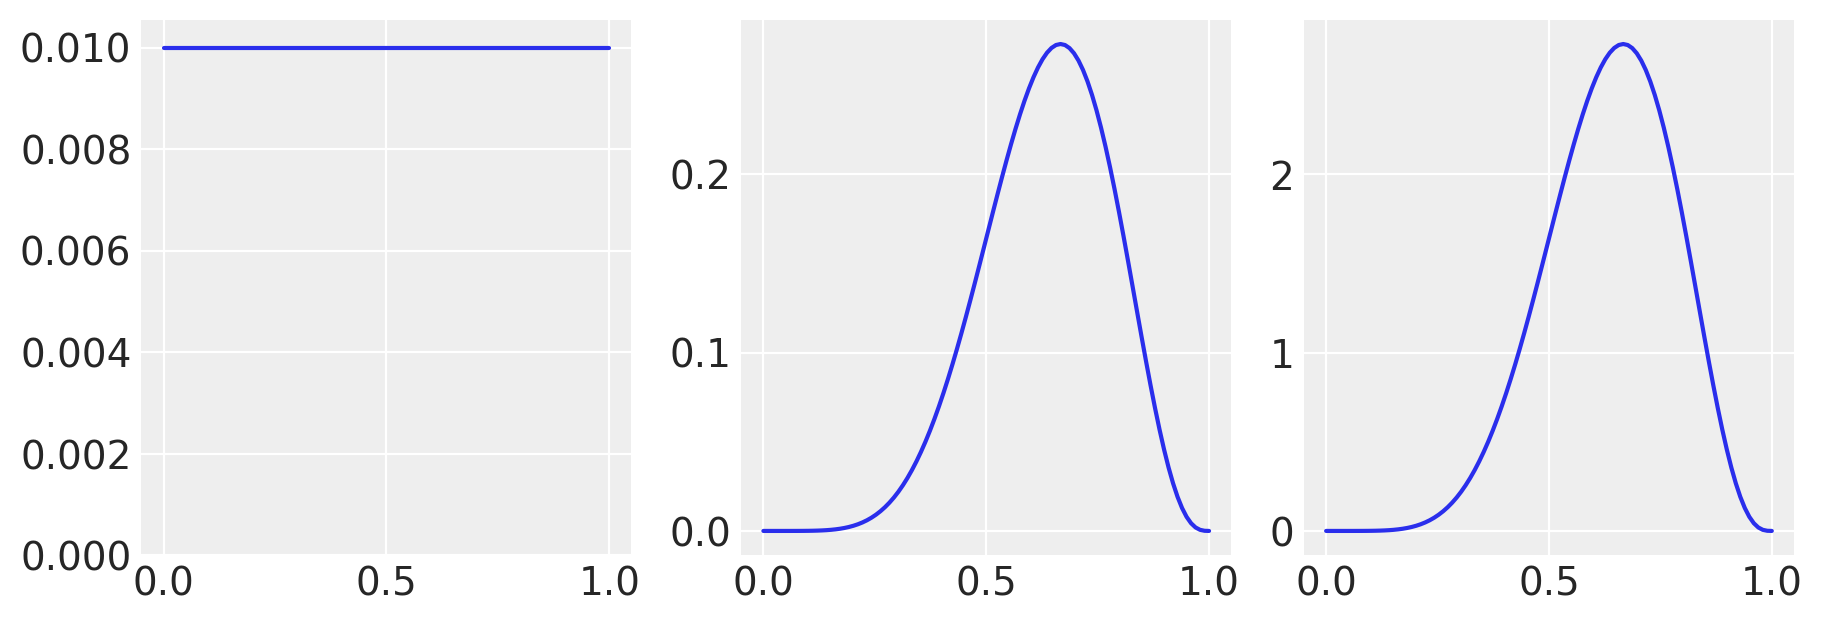

In [18]:
posterior_bin_u = lambda k, n, x: stats.beta.pdf(x, k + 1, n - k + 1)

nData = 100
n = 9
k = 6

x = np.linspace(0, 1, nData)
prior = np.ones(nData) / nData
likelihood = stats.binom.pmf(k, n, x)  # Note: Likelihood normalizes to 1 w.r.t 'k', not w.r.t 'p'
posterior = posterior_bin_u(k,n,x)

fig, ax = plt.subplots(ncols=3, figsize=(9,3))
ax[0].plot(x, prior)
ax[1].plot(x, likelihood)
ax[2].plot(x, posterior)
ax[0].set_ylim(0, None)
plt.show()

## Grid Approximation

Probability density is discretized. Posterior is computed as if it was discrete

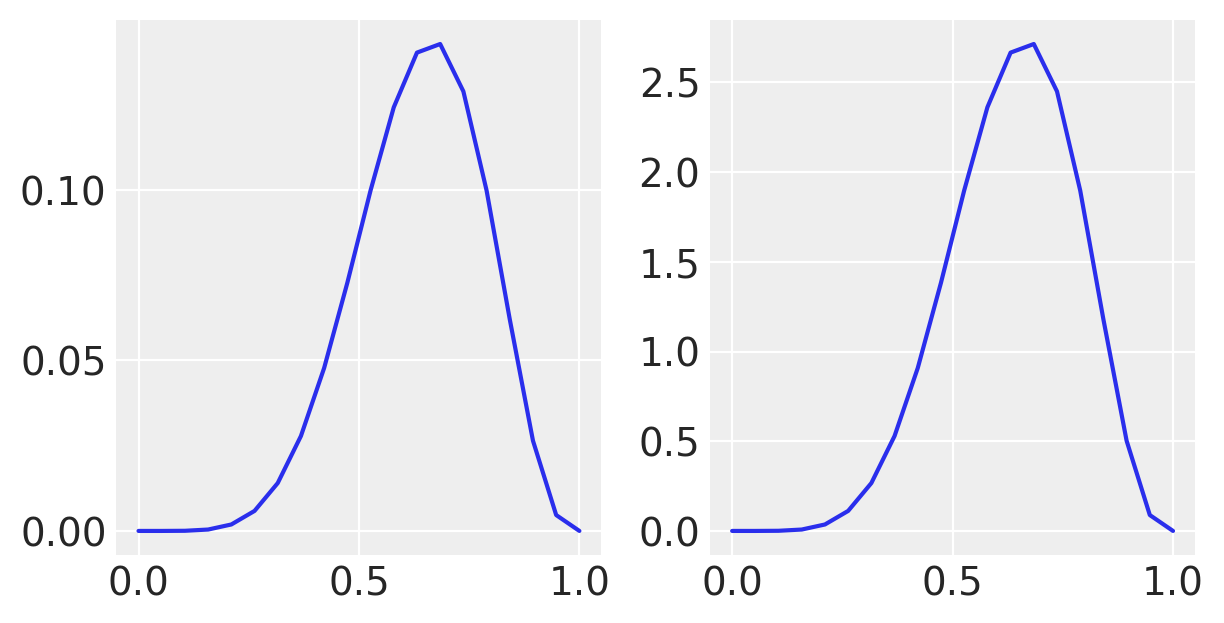

In [20]:
def posterior_grid_approx(nGridPoints=5, k=6, n=9):
    pGrid = np.linspace(0, 1, nGridPoints)

    # define prior
    prior = np.ones(nGridPoints) / nGridPoints  # uniform
    # prior = (p_grid >= 0.5).astype(int)  # truncated
    # prior = np.exp(- 5 * abs(p_grid - 0.5))  # double exp

    # compute likelihood at each point in the grid
    likelihood = stats.binom.pmf(k, n, pGrid)

    # compute product of likelihood and prior
    posterior = likelihood * prior

    # standardize the posterior, so it sums to 1
    posterior /= posterior.sum()
    return pGrid, posterior

x, postGrid = posterior_grid_approx(20, k, n)
postTrue = posterior_bin_u(k, n, x)

fig, ax = plt.subplots(ncols=2, figsize=(6,3))
ax[0].plot(x, postGrid, label='grid')
ax[1].plot(x, postTrue, label='true')
plt.show()

## Quadratic Approximation

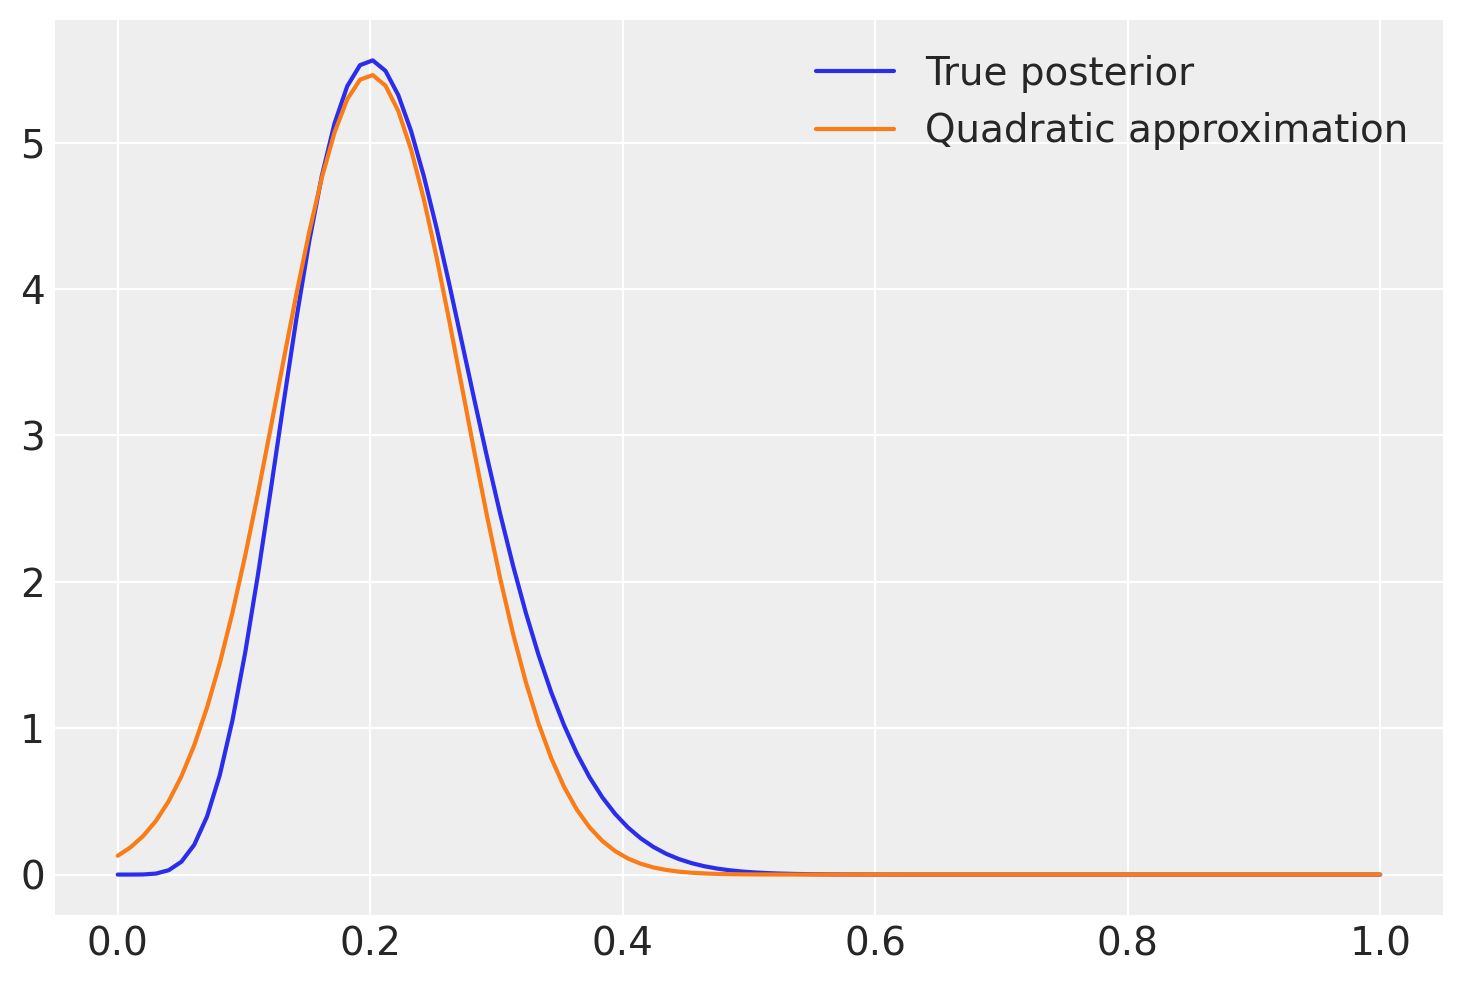

In [26]:
# Find mean and std of the posterior numerically
def quap1D_bin_u(k=6, n=9):
    with pm.Model() as normal_approximation:
        p = pm.Uniform("p", 0, 1)  # uniform priors
        w = pm.Binomial("w", n=n, p=p, observed=k)  # binomial likelihood
        muPost = pm.find_MAP()
        stdPost = ((1 / pm.find_hessian(muPost, vars=[p])) ** 0.5)[0]

    return muPost["p"], stdPost

k, n = 6, 30
x = np.linspace(0, 1, 100)
muQuap, stdQuap = quap1D_bin_u(k, n)

postTrue = posterior_bin_u(k,n,x)
postQuap = stats.norm.pdf(x, muQuap, stdQuap)   # Approximate posterior by a gaussian with est mu/std

plt.figure()
plt.plot(x, postTrue, label="True posterior")
plt.plot(x, postQuap, label="Quadratic approximation")
plt.legend(loc=0)
plt.show()

## Metropolis sampling

In [41]:
def post_metripolis(k=6, n=9, nSamples=1000):
    q_func = lambda p: stats.binom.pmf(k, n=n, p=p)

    p = np.zeros(nSamples)
    q = np.zeros(nSamples)
    p[0] = 0.5
    q[0] = q_func(p[0])
    
    for i in range(1, nSamples):
        pNew = stats.norm(p[i - 1], 0.1).rvs(1)
        if pNew < 0:
            pNew = -pNew
        if pNew > 1:
            pNew = 2 - pNew
        qNew = q_func(pNew)
        if stats.uniform.rvs(0, 1) < qNew / q[i - 1]:   # Acceptance criteria
            p[i] = pNew
            q[i] = qNew
        else:
            p[i] = p[i - 1]
            q[i] = q[i - 1]
            
    return p

In [46]:
n=9
k=6
postTrue = postTrue = posterior_bin_u(k,n,x)
postMetro = post_metripolis(k=k, n=n, nSamples=10000)

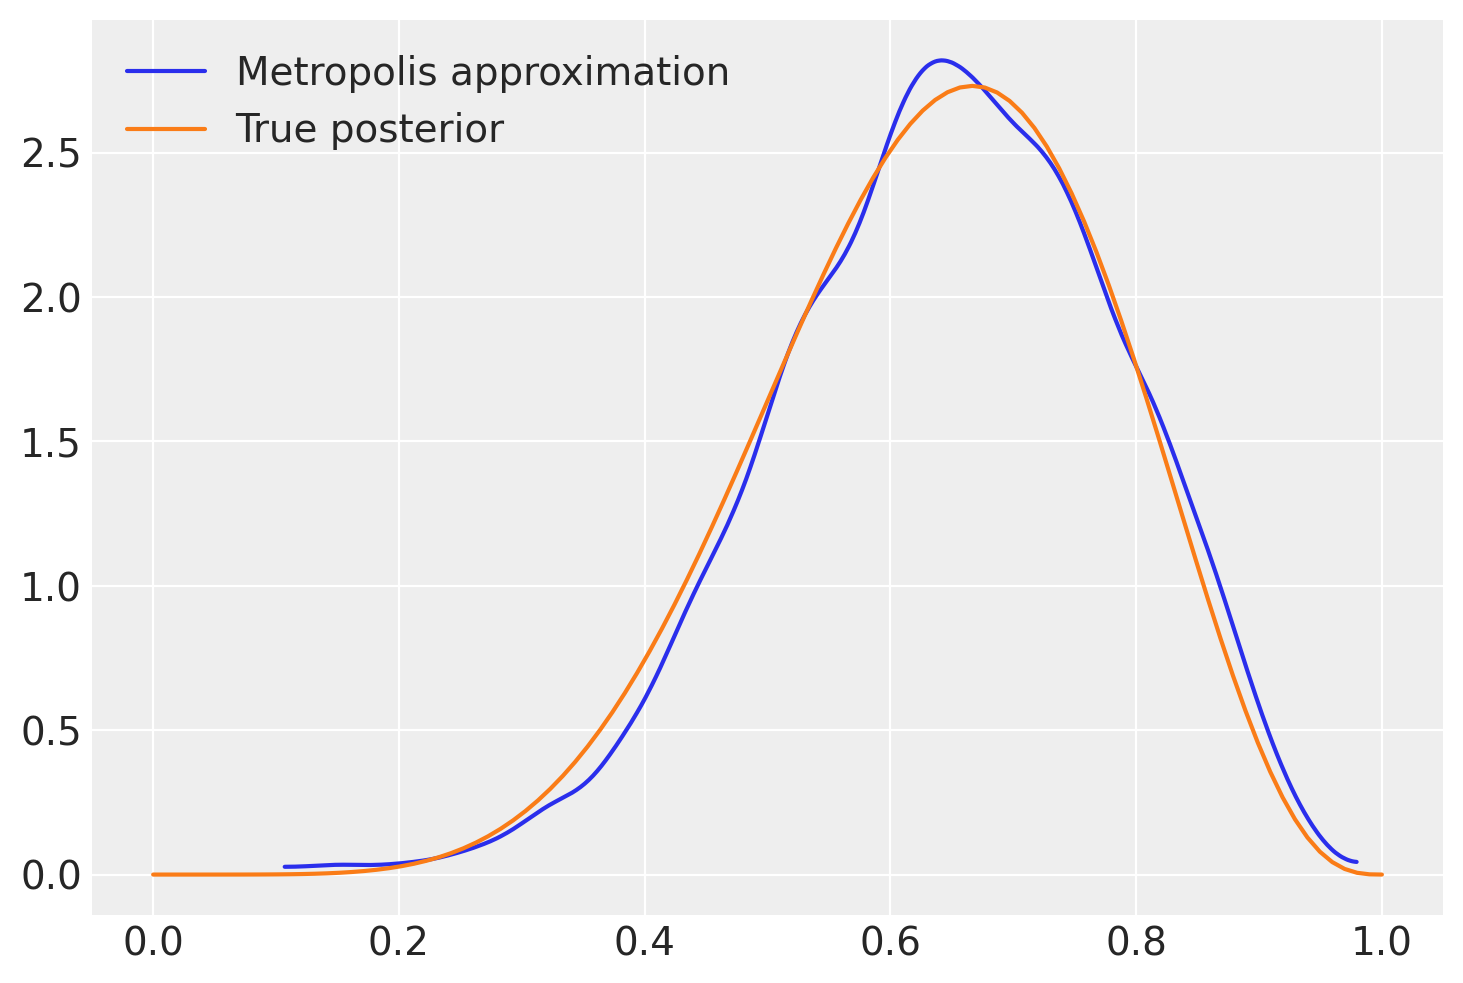

In [47]:
az.plot_kde(postMetro, label="Metropolis approximation")
x = np.linspace(0, 1, 100)
plt.plot(x, postTrue, "C1", label="True posterior")
plt.legend();